In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 1000)
pd.set_option('display.max_seq_items', 1000)

In [5]:
DATA = 'https://python3.info/_static/sensors-optima.xlsx'
LUX = 1
LIGHT_NOISE_THRESHOLD = 20 * LUX

# Locations
# - Sleeping Quarters upper
# - Kitchen Lab Table
# - Kitchen behind glovebox
# - Lab middle room
# - Bathroom
# - Gym lower
# - Sleeping Quarters lower

In [6]:
def mission_day(df):
    mission_start = df.index.min()
    mission_end = df.index.max()
    mission_days = pd.date_range(mission_start, mission_end, freq='D',
                                 normalize=True).date
    to_replace = {date: i for i, date in enumerate(mission_days)}
    return df['date'].replace(to_replace)


def was_active(df, noise_threshold=LIGHT_NOISE_THRESHOLD):
    return df['value'] > noise_threshold


df = (
    pd.read_excel(
        io=DATA,
        sheet_name='Luminance',
        header=1,
        parse_dates=['datetime'],
        usecols=['datetime', 'device', 'location', 'value', 'type'],
        index_col='datetime')
    .assign(
        date=lambda df: df.index.date,
        time=lambda df: df.index.round(freq='s').time,
        day=lambda df: mission_day(df),
        hour=lambda df: df.index.hour,
        activity=lambda df: was_active(df).astype('int'))
    .convert_dtypes()
)

In [30]:
df

,device,location,type,value,date,time,day,hour,activity
datetime,,,,,,,,,
2019-09-22 13:39:40.175384+00:00,c2a601d9-2,Sleeping Quarters upper,Luminance,360,2019-09-22,13:39:40,0,13,1
2019-09-22 13:43:34.221687+00:00,c2a601d9-4,Kitchen Lab Table,Luminance,135,2019-09-22,13:43:34,0,13,1
2019-09-22 13:45:13.101265+00:00,c2a601d9-5,Kitchen behind glovebox,Luminance,6,2019-09-22,13:45:13,0,13,0
2019-09-22 13:47:09.858619+00:00,c2a601d9-6,Lab middle room,Luminance,246,2019-09-22,13:47:10,0,13,1
2019-09-22 13:49:36.288242+00:00,c2a601d9-7,Bathroom,Luminance,0,2019-09-22,13:49:36,0,13,0
...,...,...,...,...,...,...,...,...,...
2019-09-29 11:42:04.438034+00:00,c2a601d9-9,Gym lower,Luminance,241,2019-09-29,11:42:04,7,11,1
2019-09-29 11:42:24.006685+00:00,c2a601d9-5,Kitchen behind glovebox,Luminance,9,2019-09-29,11:42:24,7,11,0
2019-09-29 11:50:41.731633+00:00,c2a601d9-3,Sleeping Quarters lower,Luminance,2,2019-09-29,11:50:42,7,11,0


In [57]:
data = (
    df
    .loc[:, ['day', 'hour', 'value']]
    .groupby(['day', 'hour'])
    .mean()
    .round()
    .astype('int16')
    .reset_index()
    .pivot(index='day', columns='hour', values='value')
)

rows = [f'Day {day}' for day in range(data.index.size)]
columns = [f'{hour:02}:00' for hour in data.columns]
values = data.values

In [48]:
values

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        123,  78, 126, 160, 143, 151, 131, 150, 150, 150,   8],
       [  1,   1,   1,   1,   1,   2,   1,  16, 142, 147, 166, 164, 164,
        165, 112,  32,  23,  26,  56,  56,  54,  68,  66,  25],
       [  0,   0,   0,   0,   0,   0,   0,  50,  58,  76, 108,  54,  66,
         68,  67,  63,  64,  66,  73,  46,  51,   0,   0,  30],
       [  0,   0,   0,   0,   0,   0,   0,   0,  28,  48,  58, 174, 153,
        154, 182, 213, 180, 213, 211, 211, 193, 213, 213,  53],
       [ 44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9,
          7, 188, 185, 186, 158, 188, 139, 122, 157, 156, 154],
       [135, 187, 154,  20,   0,   0,   0,   0,   0,   0,   0,   0, 107,
        120, 197, 193, 158, 260, 184, 182, 194, 190, 191, 170],
       [182, 210, 177, 212,   0,   0,   0,   0,   0,  31,  61,  48, 213,
        244, 206, 225, 260, 264, 192, 262, 239, 250, 264, 259],
       [226, 246, 268,   0,   0,   0,   0

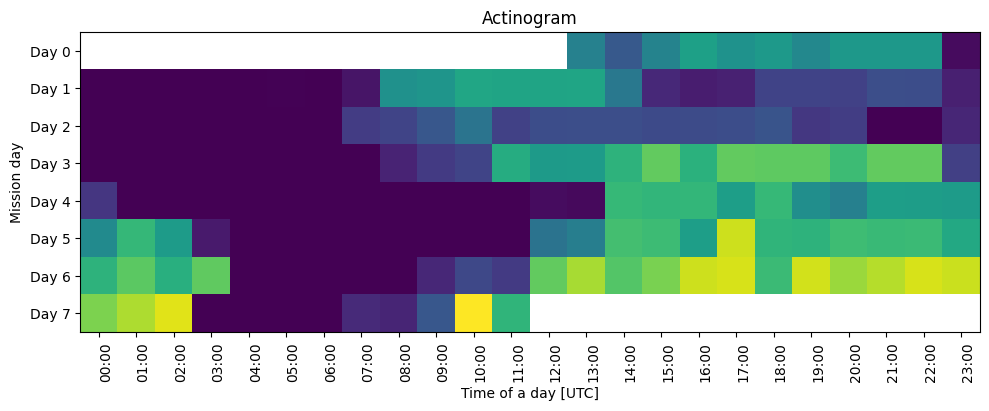

In [58]:
ax: plt.Axes
fig: plt.Figure


fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(values)


_ = ax.set_yticks(np.arange(len(rows)), labels=rows)
_ = ax.set_xticks(np.arange(len(columns)), labels=columns)
_ = plt.setp(ax.get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')

# # Loop over data dimensions and create text annotations.
# for i in range(len(rows)):
#     for j in range(len(columns)):
#         text = ax.text(j, i, harvest[i, j],
#                        ha="center", va="center", color="w")
#

ax.set_title('Actinogram')
ax.set_xlabel('Time of a day [UTC]')
ax.set_ylabel('Mission day')
fig.tight_layout()
plt.show()
